In [1]:

import cv2
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,Conv2DTranspose
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

1. Load the data

In [2]:
# read data from the folder and resize the images
img_size = 224
def load_images_from_folder(folder_path):

    images = []
    folder = os.path.join(folder_path)
    for filename in os.listdir(folder):
        if filename.endswith(".jpeg"):
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (img_size, img_size))
            if img_resized is not None :
                images.append(img_resized)
    return images

In [20]:
def resize_image(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [img_size,img_size])

In [21]:
# load and read images from the folder
train_images_pneumonia = load_images_from_folder('train/PNEUMONIA/' )
train_images_normal = load_images_from_folder('train/NORMAL/' )
test_images_pneumonia = load_images_from_folder('test/PNEUMONIA/' )
test_images_normal = load_images_from_folder('test/NORMAL/' )
val_images_pneumonia = load_images_from_folder('val/PNEUMONIA/' )
val_images_normal = load_images_from_folder('val/NORMAL/' )

In [41]:
train_images_normal

[array([[ 0,  0,  0, ..., 21,  3,  0],
        [ 0,  0,  0, ..., 17,  0,  0],
        [ 0,  0,  0, ..., 16,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[ 0,  0, 39, ...,  0,  0,  0],
        [ 0,  0, 36, ...,  0,  0,  0],
        [ 0,  0, 42, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 76,  0,  0],
        [ 0,  0,  0, ..., 86,  0,  0],
        [ 0,  0,  0, ..., 90,  0,  0]], dtype=uint8),
 array([[31, 28, 31, ..., 18, 16, 15],
        [ 6,  2,  1, ..., 15, 18, 15],
        [ 0,  0,  0, ..., 15, 17, 18],
        ...,
        [14, 13, 14, ..., 14, 14, 11],
        [18, 15, 13, ..., 12, 10, 12],
        [15, 13, 14, ..., 12, 14, 14]], dtype=uint8),
 array([[ 77,   0, 145, ..., 124,  34,  31],
        [  0,   0,   1, ...,  35,  34,  33],
        [  1,   2,   0, ...,  35,  35,  31],
        ...,
        [ 33,  39,  31, ...,  31,  26,  23],
        [ 33,  40,  3

In [3]:
train_normal = glob.glob("train"+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob("train"+"/PNEUMONIA/*.jpeg")

In [4]:
test_normal = glob.glob("test"+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob("test"+"/PNEUMONIA/*.jpeg")

In [5]:
val_normal = glob.glob("val"+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob("val"+"/PNEUMONIA/*.jpeg")

In [6]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]
df_train

,class,image
0,Normal,train/NORMAL/IM-0588-0001.jpeg
1,Normal,train/NORMAL/NORMAL2-IM-0941-0001.jpeg
2,Normal,train/NORMAL/IM-0217-0001.jpeg
3,Normal,train/NORMAL/NORMAL2-IM-0765-0001.jpeg
4,Normal,train/NORMAL/IM-0349-0001.jpeg
...,...,...
5211,Pneumonia,train/PNEUMONIA/person107_virus_197.jpeg
5212,Pneumonia,train/PNEUMONIA/person1253_bacteria_3211.jpeg
5213,Pneumonia,train/PNEUMONIA/person967_bacteria_2892.jpeg
5214,Pneumonia,train/PNEUMONIA/person437_bacteria_1888.jpeg


In [7]:
X_train = df_train['image']
y_train = df_train['class']

In [8]:
df_train['class'] = df_train['class'].replace(['Normal', 'Pneumonia'], [0, 1] )
y_train = df_train['class']
y_train

0       0
1       0
2       0
3       0
4       0
       ..
5211    1
5212    1
5213    1
5214    1
5215    1
Name: class, Length: 5216, dtype: int64

In [9]:
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]
df_test

,class,image
0,Normal,test/NORMAL/IM-0103-0001.jpeg
1,Normal,test/NORMAL/IM-0019-0001.jpeg
2,Normal,test/NORMAL/NORMAL2-IM-0352-0001.jpeg
3,Normal,test/NORMAL/NORMAL2-IM-0123-0001.jpeg
4,Normal,test/NORMAL/NORMAL2-IM-0325-0001.jpeg
...,...,...
619,Pneumonia,test/PNEUMONIA/person1633_virus_2829.jpeg
620,Pneumonia,test/PNEUMONIA/person19_virus_50.jpeg
621,Pneumonia,test/PNEUMONIA/person101_bacteria_486.jpeg
622,Pneumonia,test/PNEUMONIA/person134_bacteria_640.jpeg


In [10]:
X_test = df_test['image']
y_test = df_test['class']

In [11]:
df_test['class'] = df_test['class'].replace(['Normal', 'Pneumonia'], [0, 1] )
y_test = df_test['class']
y_test

0      0
1      0
2      0
3      0
4      0
      ..
619    1
620    1
621    1
622    1
623    1
Name: class, Length: 624, dtype: int64

In [12]:
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]
df_val

,class,image
0,Normal,val/NORMAL/NORMAL2-IM-1430-0001.jpeg
1,Normal,val/NORMAL/NORMAL2-IM-1436-0001.jpeg
2,Normal,val/NORMAL/NORMAL2-IM-1438-0001.jpeg
3,Normal,val/NORMAL/NORMAL2-IM-1437-0001.jpeg
4,Normal,val/NORMAL/NORMAL2-IM-1440-0001.jpeg
5,Normal,val/NORMAL/NORMAL2-IM-1442-0001.jpeg
6,Normal,val/NORMAL/NORMAL2-IM-1431-0001.jpeg
7,Normal,val/NORMAL/NORMAL2-IM-1427-0001.jpeg
8,Pneumonia,val/PNEUMONIA/person1949_bacteria_4880.jpeg
9,Pneumonia,val/PNEUMONIA/person1946_bacteria_4875.jpeg


In [14]:
df_val['class'] = df_val['class'].replace(['Normal', 'Pneumonia'], [0, 1] )
y_val = df_val['class']
df_val

,class,image
0,0,val/NORMAL/NORMAL2-IM-1430-0001.jpeg
1,0,val/NORMAL/NORMAL2-IM-1436-0001.jpeg
2,0,val/NORMAL/NORMAL2-IM-1438-0001.jpeg
3,0,val/NORMAL/NORMAL2-IM-1437-0001.jpeg
4,0,val/NORMAL/NORMAL2-IM-1440-0001.jpeg
5,0,val/NORMAL/NORMAL2-IM-1442-0001.jpeg
6,0,val/NORMAL/NORMAL2-IM-1431-0001.jpeg
7,0,val/NORMAL/NORMAL2-IM-1427-0001.jpeg
8,1,val/PNEUMONIA/person1949_bacteria_4880.jpeg
9,1,val/PNEUMONIA/person1946_bacteria_4875.jpeg


2. Exploring the data

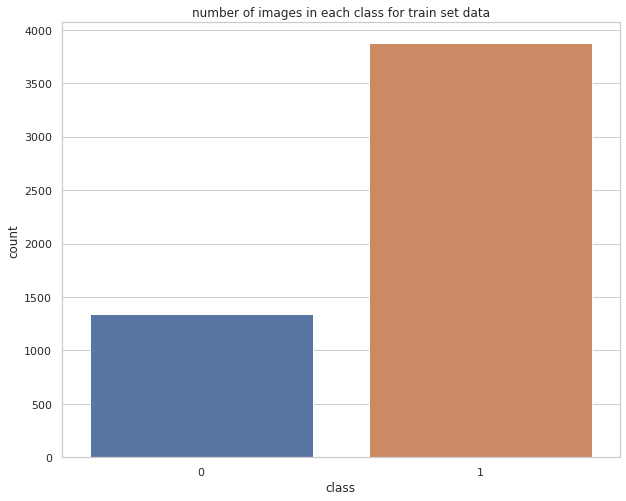

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.title("number of images in each class for train set data")
ax = sns.countplot(x="class", data=df_train)

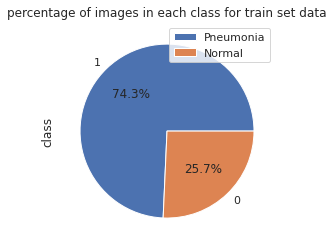

In [18]:
df_train['class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("percentage of images in each class for train set data")
plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

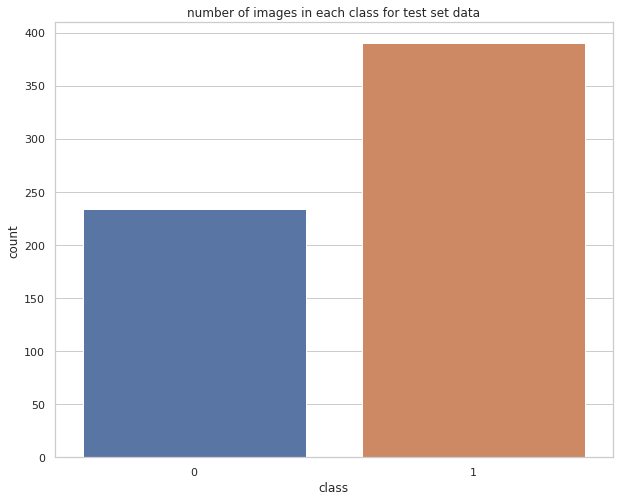

In [19]:
#for the test set
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.title("number of images in each class for test set data")
ax = sns.countplot(x="class", data=df_test)

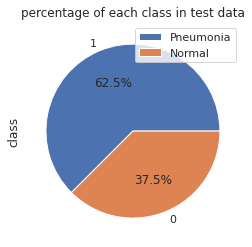

In [20]:
df_test['class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.legend(labels=['Pneumonia', 'Normal'])
plt.title("percentage of each class in test data")
plt.show()

3.Samples of train set

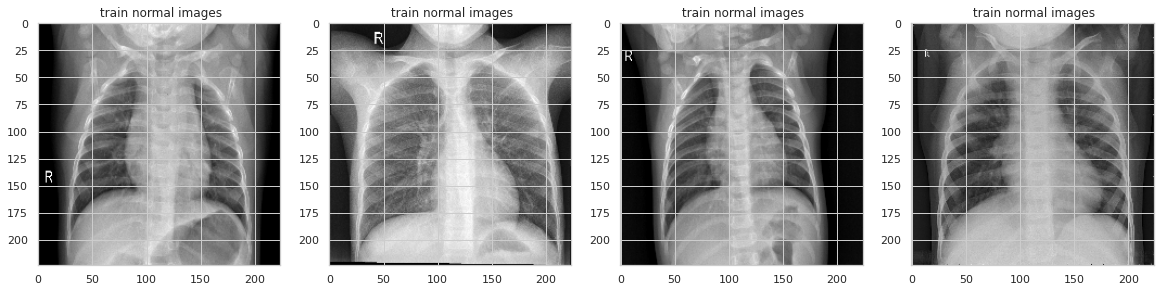

In [21]:
plt.figure(figsize=(20,20))
for i in range(0, 4):
    plt.subplot(1,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (img_size,img_size))
    plt.title(" train normal images")
    plt.imshow(img)

plt.show()

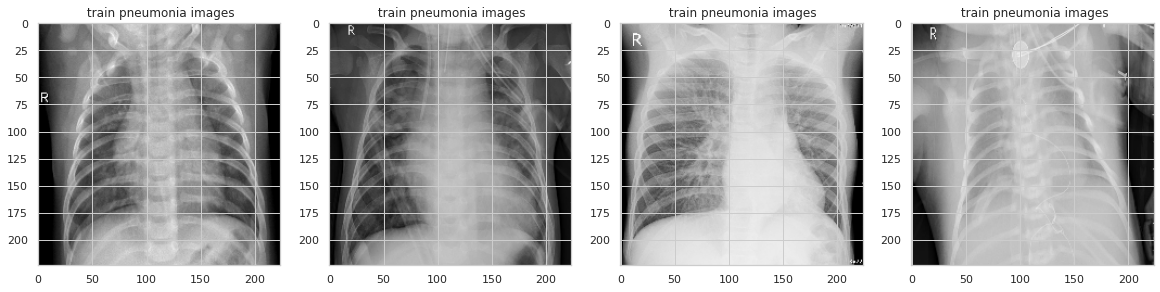

In [22]:
plt.figure(figsize=(20,20))
for i in range(0, 4):
    plt.subplot(1,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (img_size,img_size))
    plt.title(" train pneumonia images")
    plt.imshow(img)

plt.show()

# Preparing the data

In [15]:
X_train_images = np.zeros( shape = (len(df_train),img_size,img_size, 3),dtype='uint8')

i = 0
for p in df_train['image']:
    #X_train_images[i] = cv2.imread(p,cv2.IMREAD_GRAYSCALE) / 255.0  #load & scale
    img = cv2.imread(p) / 255.0
    img_resized = cv2.resize(img, (img_size, img_size))
    X_train_images[i] = img_resized
    i += 1

In [16]:
X_test_images = np.zeros( shape = (len(df_test),img_size,img_size, 3),dtype='uint8')

i = 0
for p in df_test['image']:
    #X_train_images[i] = cv2.imread(p,cv2.IMREAD_GRAYSCALE) / 255.0  #load & scale
    img = cv2.imread(p) / 255.0
    img_resized = cv2.resize(img, (img_size, img_size))
    X_test_images[i] = img_resized
    i += 1

In [17]:
X_val_images = np.zeros( shape = (len(df_val),img_size,img_size, 3),dtype='uint8')

i = 0
for p in df_val['image']:
    #X_train_images[i] = cv2.imread(p,cv2.IMREAD_GRAYSCALE) / 255.0  #load & scale
    img = cv2.imread(p) / 255.0
    img_resized = cv2.resize(img, (img_size, img_size))
    X_val_images[i] = img_resized
    i += 1

# Image Augmentation

In [56]:
from imblearn.under_sampling import RandomUnderSampler
reshaped_X = X_train_images.reshape(X_train_images.shape[0],-1)
#oversampling
undersample = RandomUnderSampler()
undersampled_X, undersampled_y  = undersample.fit_resample(reshaped_X , df_train['class'])
new_X_under = undersampled_X.reshape(-1,img_size,img_size, 3)
print(new_X_under.shape)

(2682, 224, 224, 3)


In [ ]:
undersampled_y.value_counts()

In [18]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X_train_images.reshape(X_train_images.shape[0],-1)
#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , df_train['class'])
new_X_over = oversampled_X.reshape(-1,img_size,img_size, 3)
print(new_X_over.shape)

(7750, 224, 224, 3)


In [19]:
oversampled_y.value_counts()

0    3875
1    3875
Name: class, dtype: int64

In [20]:
from PIL import Image
from matplotlib import pyplot as plt

counter = 0
for i in range(new_X_over.shape[0]):
    counter += 1
    new_X_over[i] = np.asarray(new_X_over[i], dtype=np.uint8)
    im = Image.fromarray(new_X_over[i], mode='RGB')
    # plt.imshow(im)
    # plt.show()
    if oversampled_y[i] == 'Normal':
        im.save(os.path.join('train_oversampled/NORMAL',("%s" % (str(counter))) + ".jpeg"))
    else:
        im.save(os.path.join('train_oversampled/PNEUMONIA',("%s" % (str(counter))) + ".jpeg"))

In [ ]:
counter = 0
for i in range(new_X_under.shape[0]):
    counter += 1
    new_X_under[i] = np.asarray(new_X_under[i], dtype=np.uint8)
    im = Image.fromarray(new_X_under[i], mode='RGB')
    # plt.imshow(im)
    # plt.show()
    if undersampled_y[i] == 'Normal':
        im.save(os.path.join('train_undersampled/NORMAL',("%s" % (str(counter))) + ".jpeg"))
    else:
        im.save(os.path.join('train_undersampled/PNEUMONIA',("%s" % (str(counter))) + ".jpeg"))

In [72]:
input = layers.Input(shape=(img_size, img_size, 3))
#encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoder = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (2, 2), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
decoder = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy" , metrics=["accuracy"])
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_111 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_112 (Conv2D)         (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 56, 56, 32)        9248

In [62]:

def noise(img):
    mean = 0
    var = 20
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (224, 224)) #  np.zeros((224, 224), np.float32)
    noisy_image = np.zeros(img.shape, np.float32)
    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    return noisy_image.astype(np.uint8)

In [63]:
# Create a copy of the data with added noise
noisy_train_data = noise(new_X_over[0])
#noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
#display(new_X[0], noisy_train_data)

In [64]:
print(np.amax(noisy_train_data))

255


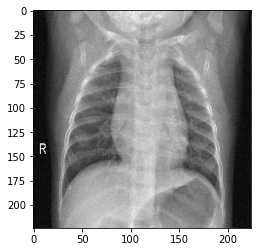

In [65]:
# plt.figure(figsize=(20,20))
plt.imshow(noisy_train_data)

In [13]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2]) # brightness


In [14]:
save_dir = "Augmentation"
train_path_oversample = 'train_oversampled'
#train_path_undersample = 'train_undersample'
train_path = 'train'
test_path = 'test'
val_path = 'val'
batch_size = 16

In [88]:
train_generator = datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_size, img_size), # resize to this size
    batch_size=batch_size, # number of images to extract from folder for every batch
    class_mode="input", # classes to predict
    seed=2022 # to make the result reproducible
)
valid_generator = datagen.flow_from_directory(
    directory=val_path,
    target_size=(img_size, img_size), # resize to this size
    batch_size=batch_size, # number of images to extract from folder for every batch
    class_mode="input", # classes to predict
    seed=2022 # to make the result reproducible
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  batch_size = 32,
                                                  shuffle = False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [89]:
history = autoencoder.fit(train_generator,
                            steps_per_epoch = 100 // batch_size,
                            epochs=20,
                            validation_data=valid_generator,
                            #validation_steps=20 // batch_size
                          )

Epoch 1/20
6/6 [==============================] - 4s 621ms/step - loss: 0.4991 - accuracy: 0.3344 - val_loss: 0.4889 - val_accuracy: 0.3209
Epoch 2/20
6/6 [==============================] - 3s 551ms/step - loss: 0.4992 - accuracy: 0.3424 - val_loss: 0.4886 - val_accuracy: 0.3327
Epoch 3/20
6/6 [==============================] - 3s 534ms/step - loss: 0.5062 - accuracy: 0.3644 - val_loss: 0.4482 - val_accuracy: 0.3927
Epoch 4/20
6/6 [==============================] - 3s 539ms/step - loss: 0.5138 - accuracy: 0.3372 - val_loss: 0.5176 - val_accuracy: 0.2225
Epoch 5/20
6/6 [==============================] - 3s 536ms/step - loss: 0.4962 - accuracy: 0.2908 - val_loss: 0.4609 - val_accuracy: 0.4100
Epoch 6/20
6/6 [==============================] - 3s 538ms/step - loss: 0.4867 - accuracy: 0.4065 - val_loss: 0.4858 - val_accuracy: 0.3805
Epoch 7/20
6/6 [==============================] - 3s 537ms/step - loss: 0.4876 - accuracy: 0.3097 - val_loss: 0.5033 - val_accuracy: 0.2722
Epoch 8/20
6/6 [====

In [14]:
train_generator = datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_size, img_size), # resize to this size
    batch_size=batch_size, # number of images to extract from folder for every batch
    class_mode="binary", # classes to predict
    seed=2022 # to make the result reproducible
)

Found 5216 images belonging to 2 classes.


In [15]:

valid_generator = datagen.flow_from_directory(
    directory=val_path,
    target_size=(img_size, img_size), # resize to this size
    batch_size=batch_size, # number of images to extract from folder for every batch
    class_mode="binary", # classes to predict
    seed=2022 # to make the result reproducible
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  #batch_size = 32,
                                                  target_size = (img_size, img_size),
                                                  shuffle = False)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# train for oversampled data
train_generator_over = datagen.flow_from_directory(
    directory=train_path_oversample,
    target_size=(img_size, img_size), # resize to this size
    batch_size=batch_size, # number of images to extract from folder for every batch
    class_mode="binary", # classes to predict
    seed=2022 # to make the result reproducible
)


Found 7750 images belonging to 2 classes.


In [91]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [92]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# Another CNN 

In [27]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_size, img_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))


In [28]:
cnn.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 93312)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [95]:
#history_cnn = cnn.fit_generator(train_generator,steps_per_epoch = 163,epochs=20,validation_data=valid_generator ,validation_steps = 624)
### for original dataset
history_cnn = cnn.fit_generator(train_generator,epochs=20,validation_data=valid_generator ,steps_per_epoch=100)

/tmp/ipykernel_4141605/273039215.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn = cnn.fit_generator(train_generator,epochs=20,validation_data=valid_generator ,steps_per_epoch=100)


Epoch 1/20
100/100 [==============================] - 28s 273ms/step - loss: 0.4778 - accuracy: 0.7881 - val_loss: 1.4383 - val_accuracy: 0.5625
Epoch 2/20
100/100 [==============================] - 27s 273ms/step - loss: 0.3888 - accuracy: 0.8031 - val_loss: 3.1208 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 26s 263ms/step - loss: 0.4018 - accuracy: 0.7994 - val_loss: 0.8502 - val_accuracy: 0.5625
Epoch 4/20
100/100 [==============================] - 27s 265ms/step - loss: 0.3353 - accuracy: 0.8356 - val_loss: 1.5340 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 27s 268ms/step - loss: 0.3266 - accuracy: 0.8469 - val_loss: 1.9781 - val_accuracy: 0.6250
Epoch 6/20
100/100 [==============================] - 27s 267ms/step - loss: 0.3149 - accuracy: 0.8587 - val_loss: 1.2292 - val_accuracy: 0.6250
Epoch 7/20
100/100 [==============================] - 26s 264ms/step - loss: 0.3035 - accuracy: 0.8619 - val_loss: 1.1397 - val_ac

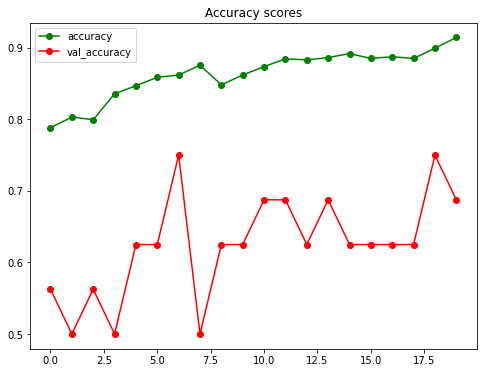

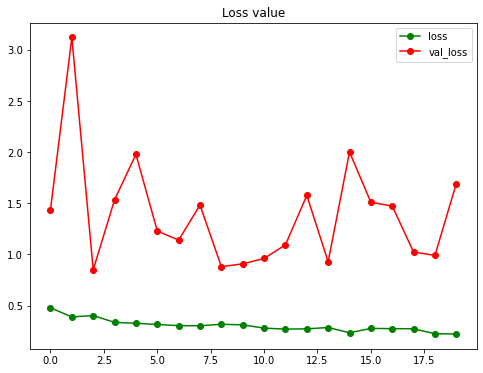

In [96]:
### for original dataset
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history_cnn.history['accuracy'],'go-')
plt.plot(history_cnn.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history_cnn.history['loss'],'go-')
plt.plot(history_cnn.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [97]:
### for original dataset
accuracy_cnn =cnn.evaluate_generator(test_generator, 624)[1]
accuracy_cnn

/tmp/ipykernel_4141605/64727623.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn =cnn.evaluate_generator(test_generator, 624)[1]


0.5

In [98]:
### for original dataset
y_pred_cnn = cnn.predict_generator(test_generator, 624)
y_pred_cnn_ = y_pred_cnn
y_pred_cnn[y_pred_cnn >= 0.5] = 1
y_pred_cnn[y_pred_cnn <  0.5] = 0
#y_pred_cnn = (y_pred).astype(int)
#y_pred
f1_score(y_test, y_pred_cnn, average=None)

/tmp/ipykernel_4141605/3383015062.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_cnn = cnn.predict_generator(test_generator, 624)


array([0.72588832, 0.8735363 ])

auc score is :  0.7837606837606839


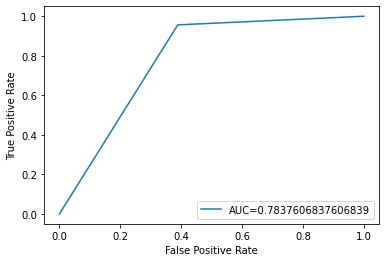

In [99]:
### for original dataset
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_cnn_)
auc = metrics.roc_auc_score(y_test, y_pred_cnn_)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [100]:
### for original dataset

predictions = y_pred_cnn.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.61      0.73       234
   Normal (Class 1)       0.80      0.96      0.87       390

           accuracy                           0.83       624
          macro avg       0.85      0.78      0.80       624
       weighted avg       0.84      0.83      0.82       624



<AxesSubplot:>

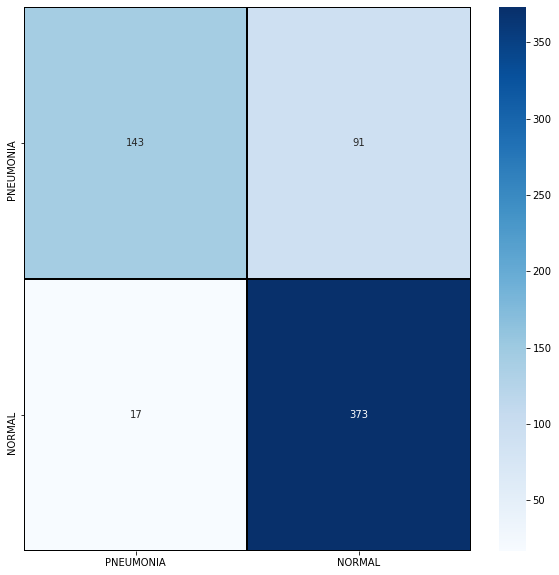

In [101]:
### for original dataset
labels = ['PNEUMONIA', 'NORMAL']
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

this part for oversample data

In [29]:
##for oversampled data
train_generator_over = datagen.flow_from_directory(
    directory=train_path_oversample,
    target_size=(img_size, img_size), # resize to this size
    #color_mode="rgb", # for coloured images
    batch_size=batch_size, # number of images to extract from folder for every batch
    class_mode="binary", # classes to predict
    seed=2022 # to make the result reproducible
)


Found 7750 images belonging to 2 classes.


In [30]:
history_cnn_over = cnn.fit_generator(train_generator_over,epochs=20,validation_data=valid_generator ,steps_per_epoch=100)

/tmp/ipykernel_88535/1935888512.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn_over = cnn.fit_generator(train_generator_over,epochs=20,validation_data=valid_generator ,steps_per_epoch=100)


Epoch 1/20
100/100 [==============================] - 20s 197ms/step - loss: 0.0594 - accuracy: 0.9900 - val_loss: 399.0915 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 19s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 444.2376 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 19s 186ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 408.3306 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 19s 192ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 454.4537 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 19s 189ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 433.7191 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 19s 190ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 421.2717 - val_accuracy: 0.5000
Epoch 7/20
100/100 [==============================] - 19s 190ms/step - loss: 0.0000e+00 - accuracy

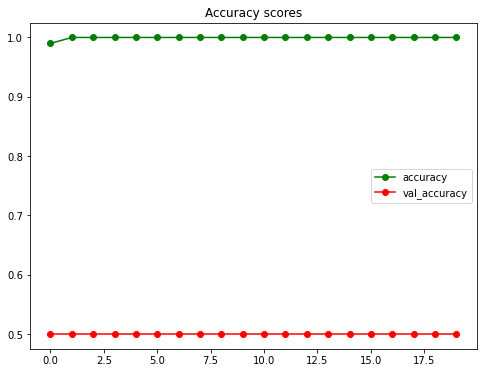

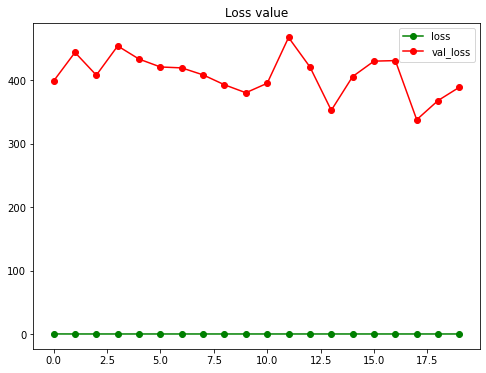

In [31]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history_cnn_over.history['accuracy'],'go-')
plt.plot(history_cnn_over.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history_cnn_over.history['loss'],'go-')
plt.plot(history_cnn_over.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [32]:
accuracy_cnn_over =cnn.evaluate_generator(test_generator, 624)[1]
accuracy_cnn_over

/tmp/ipykernel_88535/3309255977.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn_over =cnn.evaluate_generator(test_generator, 624)[1]


0.5

/tmp/ipykernel_88535/3619142563.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_cnn_over = cnn.predict_generator(test_generator, 624)


auc score is :  0.5


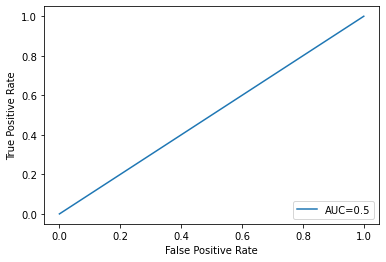

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       234
   Normal (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

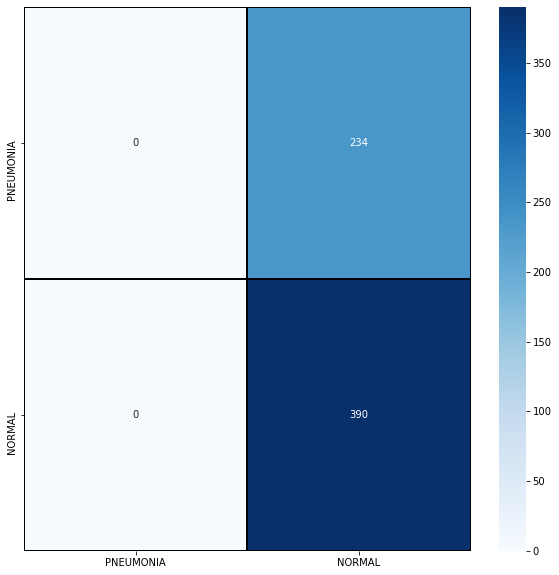

In [34]:
y_pred_cnn_over = cnn.predict_generator(test_generator, 624)
y_pred_cnn_over_ = y_pred_cnn_over
y_pred_cnn_over[y_pred_cnn_over >= 0.5] = 1
y_pred_cnn_over[y_pred_cnn_over <  0.5] = 0
#y_pred_cnn = (y_pred).astype(int)
#y_pred
#f1_score(y_test, y_pred_cnn_, average=None)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_cnn_over)
auc = metrics.roc_auc_score(y_test, y_pred_cnn_over)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
predictions = y_pred_cnn_over.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
cm = confusion_matrix(y_test,predictions)
labels = ['PNEUMONIA', 'NORMAL']
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

 # Another VGG16

In [20]:
conv_base = VGG16(include_top = False,weights='imagenet')
for i in conv_base.layers:
    i.trainable=False
X = conv_base.output
X = layers.GlobalAveragePooling2D()(X)
X = layers.Dense(128,activation='relu')(X)
predictions = layers.Dense(1,activation='sigmoid')(X)
model_vgg_16= Model(conv_base.input,predictions)
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model_vgg_16.compile(loss='binary_crossentropy',
              optimizer= tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

2022-05-06 14:43:35.514063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:43:35.520386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/samiraalkaee/anaconda3/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-06 14:43:35.520401: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-06 14:43:35.520758: I tensorflow/core/platform/cpu_feature_guard

In [21]:
model_vgg_16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:
history_vgg16 = model_vgg_16.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs=20,
    validation_data = valid_generator,
    #validation_steps=25
)

Epoch 1/20
100/100 [==============================] - 79s 787ms/step - loss: 0.5233 - accuracy: 0.7600 - val_loss: 0.9006 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 72s 719ms/step - loss: 0.4280 - accuracy: 0.8050 - val_loss: 0.7090 - val_accuracy: 0.5625
Epoch 3/20
100/100 [==============================] - 72s 723ms/step - loss: 0.4044 - accuracy: 0.8119 - val_loss: 1.1593 - val_accuracy: 0.6250
Epoch 4/20
100/100 [==============================] - 72s 719ms/step - loss: 0.3694 - accuracy: 0.8375 - val_loss: 0.8616 - val_accuracy: 0.6250
Epoch 5/20
100/100 [==============================] - 77s 769ms/step - loss: 0.3456 - accuracy: 0.8569 - val_loss: 1.0664 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 73s 731ms/step - loss: 0.3195 - accuracy: 0.8631 - val_loss: 0.7020 - val_accuracy: 0.6875
Epoch 7/20
100/100 [==============================] - 73s 727ms/step - loss: 0.3021 - accuracy: 0.8731 - val_loss: 0.9591 - val_ac

In [11]:
accuracy_vgg =model_vgg_16.evaluate_generator(test_generator,624)[1]
accuracy_vgg


/tmp/ipykernel_55563/2659328574.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg =model_vgg_16.evaluate_generator(test_generator,624)[1]


0.5

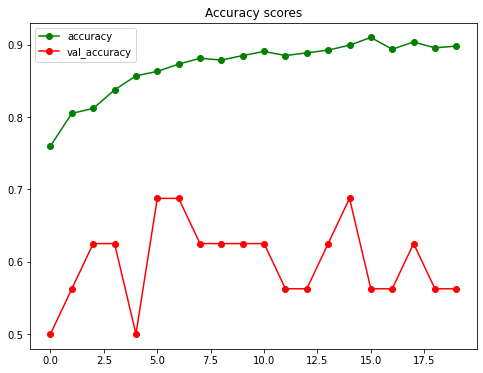

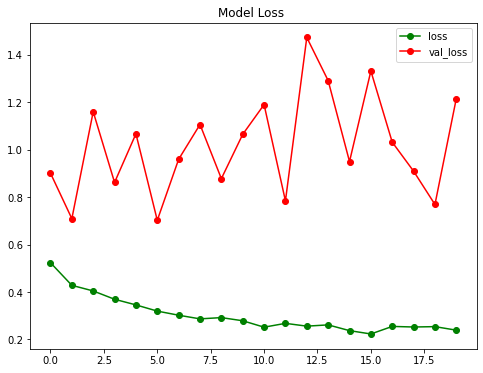

In [12]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history_vgg16.history['accuracy'],'go-')
plt.plot(history_vgg16.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Model Loss ')
plt.plot(history_vgg16.history['loss'],'go-')
plt.plot(history_vgg16.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [13]:
y_pred_vgg = model_vgg_16.predict_generator(test_generator,624)
#y_pred

/tmp/ipykernel_55563/2706616237.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_vgg = model_vgg_16.predict_generator(test_generator,624)


In [14]:
y_pred_vgg[y_pred_vgg >= 0.5] = 1
y_pred_vgg[y_pred_vgg <  0.5] = 0
#y_pred = (y_pred).astype(int)
y_pred_vgg

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],

In [16]:
#f1_score(y_test, y_pred_vgg, average=None)

auc score is :  0.8598290598290598


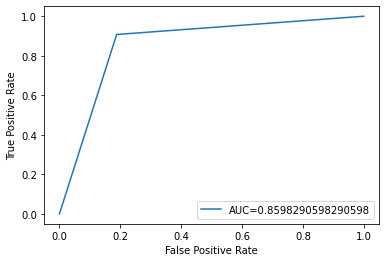

In [32]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_vgg)
auc = metrics.roc_auc_score(y_test, y_pred_vgg)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [35]:

predictions = y_pred_vgg.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.81      0.83       234
   Normal (Class 1)       0.89      0.91      0.90       390

           accuracy                           0.87       624
          macro avg       0.87      0.86      0.86       624
       weighted avg       0.87      0.87      0.87       624



<AxesSubplot:>

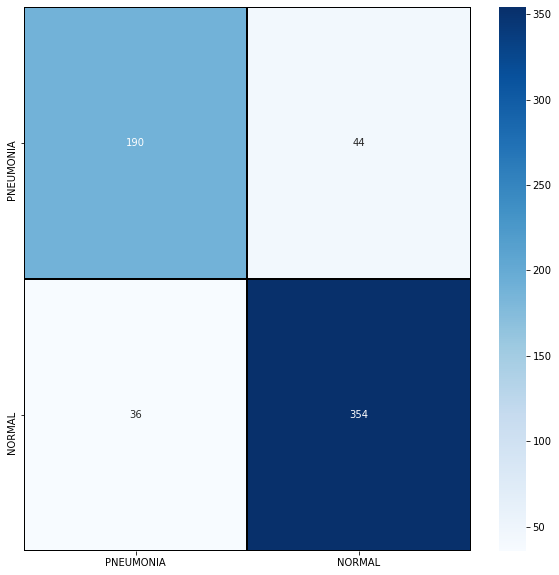

In [37]:
labels = ['PNEUMONIA', 'NORMAL']
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

for over sampling

In [22]:
##oversampling
history_vgg16_over = model_vgg_16.fit(
    train_generator_over,
    steps_per_epoch = 100,
    epochs=20,
    validation_data = valid_generator,
    #validation_steps=25
)


Epoch 1/20
100/100 [==============================] - 72s 715ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 4.6573 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 69s 693ms/step - loss: 7.1212e-05 - accuracy: 1.0000 - val_loss: 6.2083 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 70s 699ms/step - loss: 9.2439e-06 - accuracy: 1.0000 - val_loss: 6.7844 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 69s 692ms/step - loss: 3.8787e-06 - accuracy: 1.0000 - val_loss: 7.2422 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 73s 727ms/step - loss: 2.1856e-06 - accuracy: 1.0000 - val_loss: 7.4384 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 81s 805ms/step - loss: 1.4105e-06 - accuracy: 1.0000 - val_loss: 7.6455 - val_accuracy: 0.5000
Epoch 7/20
100/100 [==============================] - 76s 758ms/step - loss: 9.8974e-07 - accuracy: 1.0000 - v

In [23]:
accuracy_vgg_over =model_vgg_16.evaluate_generator(test_generator, 624)[1]

/tmp/ipykernel_96675/1196551854.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg_over =model_vgg_16.evaluate_generator(test_generator, 624)[1]


/tmp/ipykernel_96675/1960538897.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_vgg16_over = model_vgg_16.predict_generator(test_generator, 624)


auc score is :  0.5


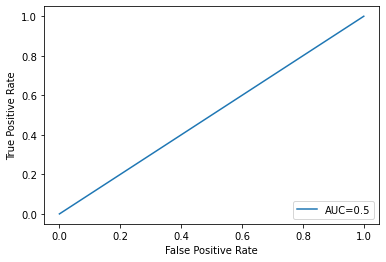

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       234
   Normal (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

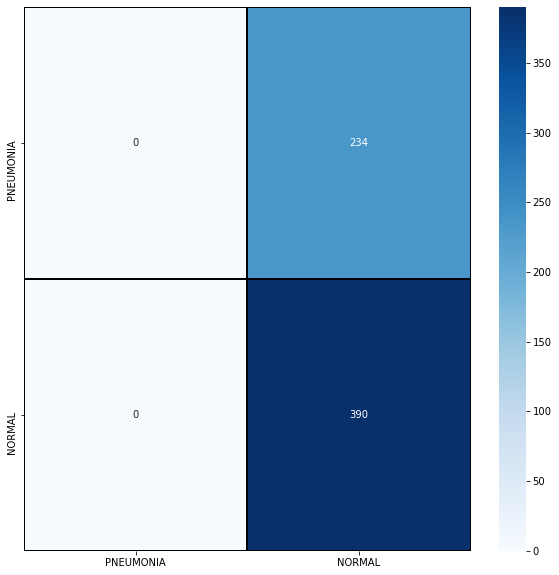

In [24]:
y_pred_vgg16_over = model_vgg_16.predict_generator(test_generator, 624)
y_pred_vgg16_over_ = y_pred_vgg16_over
y_pred_vgg16_over[y_pred_vgg16_over >= 0.5] = 1
y_pred_vgg16_over[y_pred_vgg16_over <  0.5] = 0
#y_pred_cnn = (y_pred).astype(int)
#y_pred
#f1_score(y_test, y_pred_cnn_, average=None)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_vgg16_over)
auc = metrics.roc_auc_score(y_test, y_pred_vgg16_over)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
predictions = y_pred_vgg16_over.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
cm = confusion_matrix(y_test,predictions)
labels = ['PNEUMONIA', 'NORMAL']
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

# ResNet

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D,BatchNormalization
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [26]:
resnet=ResNet50(input_shape=[img_size,img_size,3],weights='imagenet',include_top=False)

In [115]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [27]:
for layers in resnet.layers[:50]:
    layers.trainable=False
x = Flatten()(resnet.output)
prediction = Dense(1, activation='sigmoid')(x)
model_res = Model(inputs=resnet.input, outputs=prediction)
model_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [29]:
model_res.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [118]:
history = model_res.fit_generator(train_generator,validation_data = valid_generator,epochs = 20 , steps_per_epoch = 100)

/tmp/ipykernel_4141605/1723560678.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_res.fit_generator(train_generator,validation_data = valid_generator,epochs = 20 , steps_per_epoch = 100)


Epoch 1/20
100/100 [==============================] - 97s 948ms/step - loss: 1.7031 - acc: 0.6913 - val_loss: 206.1106 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 95s 944ms/step - loss: 0.5811 - acc: 0.7325 - val_loss: 1.4118 - val_acc: 0.5000
Epoch 3/20
100/100 [==============================] - 95s 943ms/step - loss: 0.5599 - acc: 0.7400 - val_loss: 3.7247 - val_acc: 0.5000
Epoch 4/20
100/100 [==============================] - 93s 929ms/step - loss: 0.5409 - acc: 0.7281 - val_loss: 0.8349 - val_acc: 0.5625
Epoch 5/20
100/100 [==============================] - 91s 908ms/step - loss: 0.5269 - acc: 0.7362 - val_loss: 14.6931 - val_acc: 0.5000
Epoch 6/20
100/100 [==============================] - 91s 908ms/step - loss: 0.4751 - acc: 0.7569 - val_loss: 20.6968 - val_acc: 0.5000
Epoch 7/20
100/100 [==============================] - 91s 908ms/step - loss: 0.4533 - acc: 0.7894 - val_loss: 1.8338 - val_acc: 0.5625
Epoch 8/20
100/100 [==============================]

In [119]:
accuracy_res =model_res.evaluate_generator(test_generator,624)[1]
accuracy_res

/tmp/ipykernel_4141605/2365980134.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_res =model_res.evaluate_generator(test_generator,624)[1]


0.5

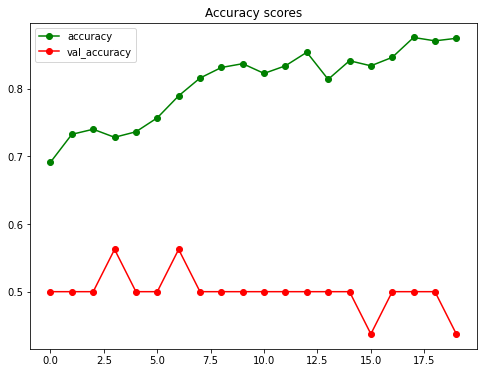

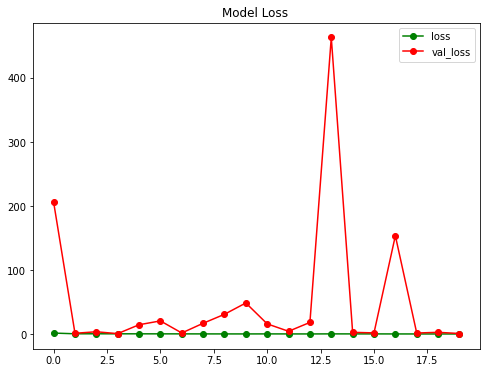

In [120]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'],'go-')
plt.plot(history.history['val_acc'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Model Loss ')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [121]:
y_pred_res = model_res.predict_generator(test_generator,624)
y_pred_res

/tmp/ipykernel_4141605/3307631548.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_res = model_res.predict_generator(test_generator,624)


array([[1.13998711e-01],
       [8.06038082e-02],
       [5.33522367e-02],
       [1.44374311e-01],
       [4.98447120e-02],
       [4.04691070e-01],
       [9.94855165e-02],
       [7.97829330e-02],
       [1.22518629e-01],
       [8.58772695e-02],
       [7.79262185e-02],
       [1.06032282e-01],
       [5.83873987e-02],
       [1.04895324e-01],
       [7.20992982e-02],
       [2.12869614e-01],
       [8.56868923e-02],
       [1.34898990e-01],
       [5.66653907e-02],
       [1.46022081e-01],
       [1.06551915e-01],
       [9.32061672e-02],
       [6.19305372e-02],
       [6.87866509e-02],
       [7.75018334e-02],
       [5.64525723e-02],
       [7.80051649e-02],
       [7.93774426e-02],
       [1.07682198e-01],
       [7.61977136e-02],
       [6.64519072e-02],
       [2.64149010e-02],
       [6.65056109e-02],
       [4.37492728e-02],
       [9.00362134e-02],
       [7.15390444e-02],
       [8.10015202e-02],
       [6.23387098e-02],
       [5.42873442e-02],
       [1.02935433e-01],


In [122]:
y_pred_res[y_pred_res >= 0.5] = 1
y_pred_res[y_pred_res <  0.5] = 0

In [123]:
f1_score(y_test , y_pred_res , average = 'binary')

0.035175879396984924

auc score is :  0.5068376068376068


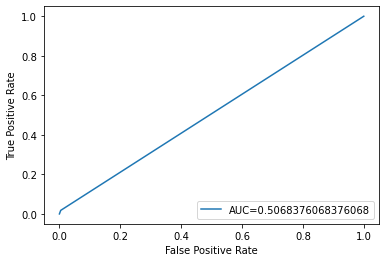

In [124]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_res)
auc = metrics.roc_auc_score(y_test, y_pred_res)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [125]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = y_pred_res.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.38      1.00      0.55       234
   Normal (Class 1)       0.88      0.02      0.04       390

           accuracy                           0.38       624
          macro avg       0.63      0.51      0.29       624
       weighted avg       0.69      0.38      0.23       624



<AxesSubplot:>

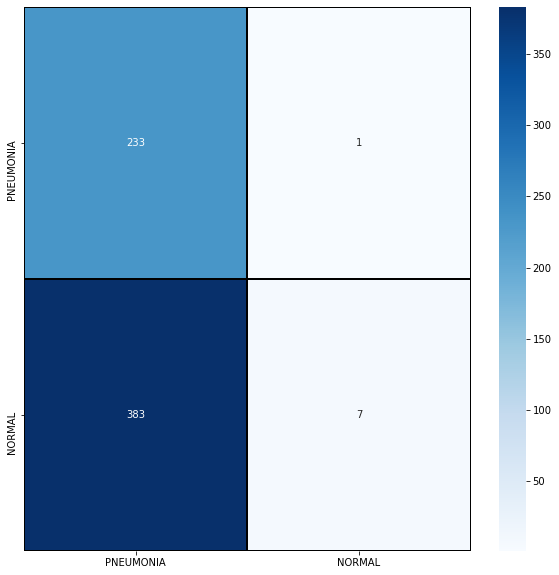

In [126]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

This part for oversampling

In [30]:
##oversampling
history_resnet_over = model_res.fit(
    train_generator_over,
    steps_per_epoch = 100,
    epochs=20,
    validation_data = valid_generator,
    #validation_steps=25
)

Epoch 1/20
100/100 [==============================] - 97s 946ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 23.0298 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 90s 898ms/step - loss: 1.7793e-37 - acc: 1.0000 - val_loss: 33.2418 - val_acc: 0.5000
Epoch 3/20
100/100 [==============================] - 93s 924ms/step - loss: 1.7906e-37 - acc: 1.0000 - val_loss: 38.8046 - val_acc: 0.5000
Epoch 4/20
100/100 [==============================] - 105s 1s/step - loss: 6.0365e-36 - acc: 1.0000 - val_loss: 39.8833 - val_acc: 0.5000
Epoch 5/20
100/100 [==============================] - 100s 1s/step - loss: 1.7946e-37 - acc: 1.0000 - val_loss: 40.4515 - val_acc: 0.5000
Epoch 6/20
100/100 [==============================] - 90s 895ms/step - loss: 1.9377e-37 - acc: 1.0000 - val_loss: 41.3719 - val_acc: 0.5000
Epoch 7/20
100/100 [==============================] - 89s 889ms/step - loss: 1.7711e-37 - acc: 1.0000 - val_loss: 41.2226 - val_acc: 0.5000
Epoch 8/20
100/100 [========

/tmp/ipykernel_96675/823195376.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_res_over = model_res.evaluate_generator(test_generator, 624)[1]


/tmp/ipykernel_96675/823195376.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_res_over = model_res.predict_generator(test_generator, 624)


auc score is :  0.5


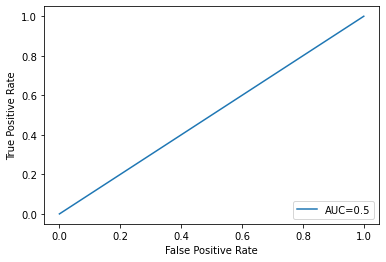

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       234
   Normal (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

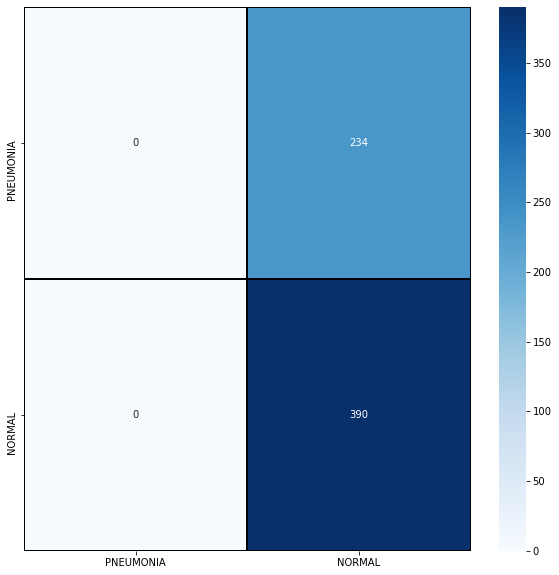

In [31]:
accuracy_res_over = model_res.evaluate_generator(test_generator, 624)[1]
y_pred_res_over = model_res.predict_generator(test_generator, 624)
y_pred_res_over_ = y_pred_res_over
y_pred_res_over[y_pred_res_over >= 0.5] = 1
y_pred_res_over[y_pred_res_over < 0.5] = 0
#y_pred_cnn = (y_pred).astype(int)
#y_pred
#f1_score(y_test, y_pred_cnn_, average=None)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_res_over)
auc = metrics.roc_auc_score(y_test, y_pred_res_over)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
predictions = y_pred_res_over.reshape(1, -1)[0]
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))
cm = confusion_matrix(y_test, predictions)
labels = ['PNEUMONIA', 'NORMAL']
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels,
            yticklabels=labels)

#  CRNN

In [17]:
#Recurrent CNN
# example of creating a CNN with an inception module
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
import tensorflow as tf
import json
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation, Dot, GlobalAveragePooling2D, AveragePooling2D, TimeDistributed, RepeatVector, Bidirectional, Input, Dense, Concatenate, concatenate, Conv1D, Conv2D, Conv3D
from keras.layers import GRU, Lambda, MaxPooling1D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, LSTM, Flatten, Reshape, Dropout, BatchNormalization, MaxPooling3D
from keras.models import Sequential, Model
from keras import regularizers
#from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.layers import Layer, Reshape
from statistics import mode
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold, train_test_split
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import StandardScaler, normalize
from keras.layers.convolutional import Convolution3D, MaxPooling3D, UpSampling3D
from time import time
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import KFold, StratifiedKFold
import os
import math
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, Lambda, Dropout, Activation, LSTM, GRU, TimeDistributed, Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Permute, ZeroPadding2D, Reshape, merge, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, TimeDistributed
from keras.layers.local import LocallyConnected1D
from keras.layers.advanced_activations import ELU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from keras import backend as K
from keras.models import Model
from keras.models import load_model
from sklearn.model_selection import train_test_split

class Attention(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):

        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False)(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,))(hidden_states)
        score = Dot(axes=[1, 2])([h_t, score_first_part])
        attention_weights = Activation('softmax')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1])([hidden_states, attention_weights])
        pre_activation = Concatenate()([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, activation='tanh')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)



def build_CRNN_model():
    i = Input(shape=(img_size, img_size, 3))

    c1 = Conv2D(32, kernel_size=1, padding='same', activation='relu', dilation_rate=2)(i)
    p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)
    p1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(p1)
    n1 = BatchNormalization()(p1)


    c2 = Conv2D(32, kernel_size=1, padding='same', activation='relu', dilation_rate=2)(n1)
    c2 = Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu')(c2)
    p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)
    p2 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(p2)
    n2 = BatchNormalization()(p2)


    c3 = Conv2D(32, kernel_size=1, padding='same', activation='relu', dilation_rate=2)(n2)
    c3 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(c3)
    p3 = MaxPooling2D((2, 2), strides=(2, 2))(c3)
    p3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(p3)
    n3 = BatchNormalization()(p3)


    n3 = Conv2D(32, kernel_size=1, padding='same', activation='relu', dilation_rate=2)(n3)
    c4 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(n3)
    p4 = MaxPooling2D((2, 1), strides=(1, 1))(c4)
    p4 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(p4)
    n4 = BatchNormalization()(p4)


    n4 = Conv2D(32, kernel_size=1, padding='same', activation='relu', dilation_rate=2)(n4)
    # c5 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(n4)
    # p5 = MaxPooling2D((2, 1), strides=(1, 1))(c5)
    # p5 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(p5)
    # n5 = BatchNormalization()(p5)


    f = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(n4)
    f = BatchNormalization()(f)
    f = Activation('relu')(f)
    f = GlobalAveragePooling2D()(f)

    lstm = Bidirectional(LSTM(64, return_sequences=True))(i[:,:,:,0])
    l = Flatten()(lstm)
    #attention = Attention(128)(lstm)

    #Concat output
    concat = concatenate([f, l], axis=-1)
    out = Dense(1)(concat)
    model = Model(outputs=out, inputs=i)

    return model


lr_change = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=0.000, verbose=1)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, mode='min')
callbacks =[lr_change, early_stopping]
opt = Adam(lr=0.001)
classifier = build_CRNN_model()
classifier.summary()

# compile model
classifier.compile(optimizer=opt,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-05-06 16:04:43.830002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 16:04:43.835430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/samiraalkaee/anaconda3/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-06 16:04:43.835443: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://ww

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
history_CRNN = classifier.fit_generator(train_generator,epochs=20,validation_data=valid_generator ,steps_per_epoch=100 )

/tmp/ipykernel_78543/927866513.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_CRNN = classifier.fit_generator(train_generator,epochs=20,validation_data=valid_generator ,steps_per_epoch=100 )


Epoch 1/20
100/100 [==============================] - 40s 378ms/step - loss: 3.7935 - accuracy: 0.7450 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 36s 360ms/step - loss: 3.9457 - accuracy: 0.7412 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 36s 357ms/step - loss: 3.9267 - accuracy: 0.7425 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 36s 356ms/step - loss: 3.8028 - accuracy: 0.7506 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 36s 356ms/step - loss: 4.0125 - accuracy: 0.7369 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 36s 356ms/step - loss: 4.0220 - accuracy: 0.7362 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/20
100/100 [==============================] - 35s 343ms/step - loss: 3.9076 - accuracy: 0.7437 - val_loss: 7.6246 - val_ac

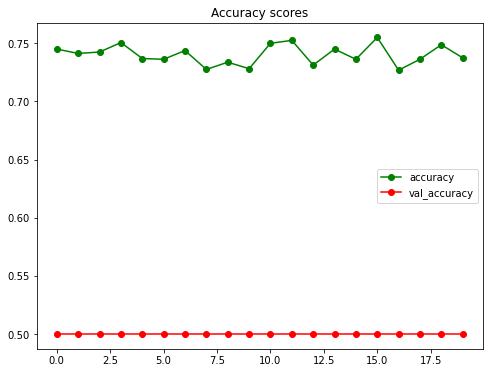

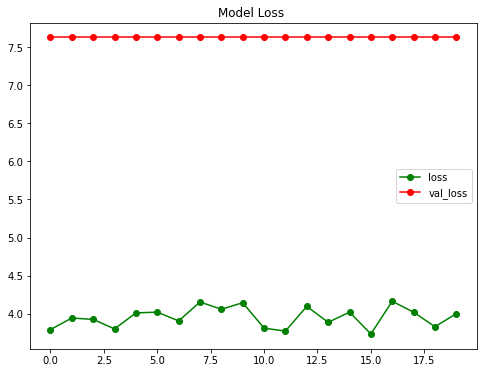

In [18]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history_CRNN.history['accuracy'],'go-')
plt.plot(history_CRNN.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Model Loss ')
plt.plot(history_CRNN.history['loss'],'go-')
plt.plot(history_CRNN.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [19]:
y_pred_CRNN = classifier.predict_generator(test_generator,624)
y_pred_CRNN

/tmp/ipykernel_78543/2239157858.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_CRNN = classifier.predict_generator(test_generator,624)


array([[44.66828 ],
       [45.71282 ],
       [45.408936],
       [46.613197],
       [45.259342],
       [46.3995  ],
       [44.687912],
       [45.05572 ],
       [44.395924],
       [43.754524],
       [45.147007],
       [45.274845],
       [45.06508 ],
       [45.545197],
       [45.10871 ],
       [46.56136 ],
       [38.369553],
       [44.63783 ],
       [44.85108 ],
       [45.575035],
       [44.37318 ],
       [46.29219 ],
       [41.072777],
       [45.78254 ],
       [46.62703 ],
       [46.3863  ],
       [46.11499 ],
       [44.404274],
       [47.331085],
       [45.472626],
       [44.98142 ],
       [41.611496],
       [45.77378 ],
       [46.303978],
       [45.71283 ],
       [43.316753],
       [44.67154 ],
       [44.935337],
       [45.01705 ],
       [42.621777],
       [41.000298],
       [42.342747],
       [43.82917 ],
       [41.928978],
       [45.235085],
       [44.88405 ],
       [44.28243 ],
       [44.80603 ],
       [45.147392],
       [43.52562 ],


In [20]:
y_pred_CRNN_ = y_pred_CRNN
y_pred_CRNN[y_pred_CRNN >= 0.5] = 1
y_pred_CRNN[y_pred_CRNN <  0.5] = 0

f1 score is:  0.7692307692307693
auc score is :  0.5


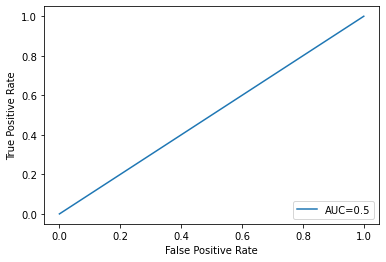

In [21]:
f1_score = f1_score(y_test, y_pred_CRNN_, average='binary')
print("f1 score is: ", f1_score)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_CRNN_)
auc = metrics.roc_auc_score(y_test, y_pred_CRNN_)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [22]:

predictions = y_pred_CRNN.reshape(1, -1)[0]
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       234
   Normal (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

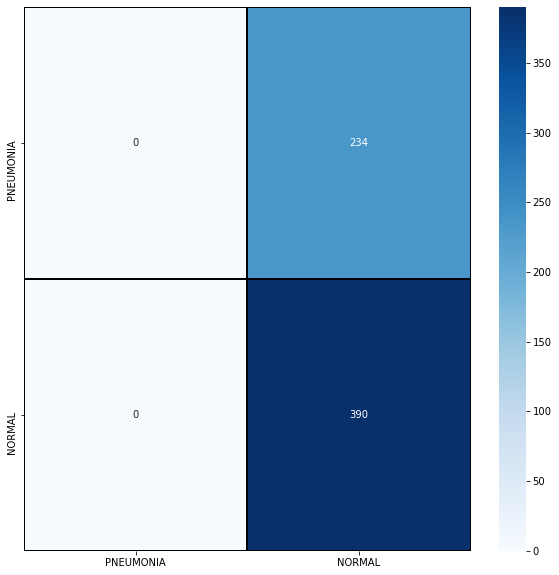

In [24]:
labels = ['PNEUMONIA', 'NORMAL']
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels,
            yticklabels=labels)

Oversample part

In [34]:
history_classifier_over = classifier.fit(
    train_generator_over,
    steps_per_epoch = 100,
    epochs=20,
    validation_data = valid_generator,
    #validation_steps=25
)

Epoch 1/20
100/100 [==============================] - 39s 365ms/step - loss: 4.1533 - accuracy: 0.6900 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 36s 357ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 34s 341ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 33s 334ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 34s 340ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 33s 331ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/20
100/100 [==============================] - 35s 346ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - v

/tmp/ipykernel_96675/3600030980.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_classifier_over = classifier.evaluate_generator(test_generator, 624)[1]


/tmp/ipykernel_96675/3600030980.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_classifier_over = classifier.predict_generator(test_generator, 624)


auc score is :  0.5


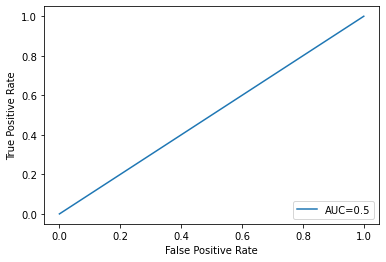

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       234
   Normal (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

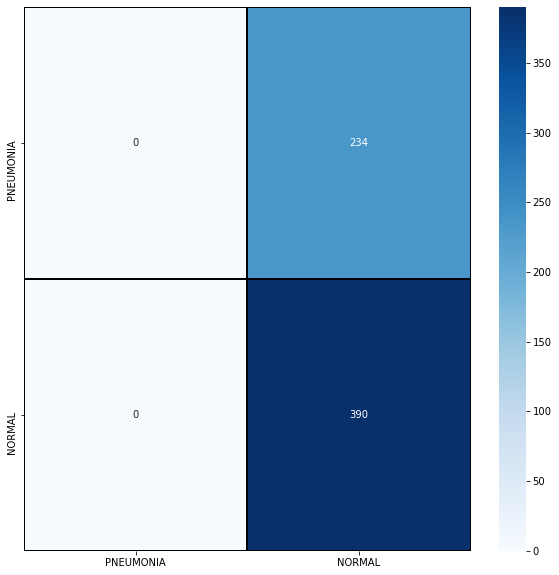

In [35]:
accuracy_classifier_over = classifier.evaluate_generator(test_generator, 624)[1]
y_pred_classifier_over = classifier.predict_generator(test_generator, 624)
y_pred_classifier_over_ = y_pred_classifier_over
y_pred_classifier_over[y_pred_classifier_over >= 0.5] = 1
y_pred_classifier_over[y_pred_classifier_over < 0.5] = 0
#y_pred_cnn = (y_pred).astype(int)
#y_pred
#f1_score(y_test, y_pred_cnn_, average=None)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_classifier_over)
auc = metrics.roc_auc_score(y_test, y_pred_classifier_over)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
predictions = y_pred_classifier_over.reshape(1, -1)[0]
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))
cm = confusion_matrix(y_test, predictions)
labels = ['PNEUMONIA', 'NORMAL']
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels,
            yticklabels=labels)

# Another model

In [18]:
from keras.layers import UpSampling2D
from keras.layers import Conv2D
def AE():

    input = Input(shape=(img_size, img_size, 3))
    #encoder
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    encoder = MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoder)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoder = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    i = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(encoder)
    i = BatchNormalization()(i)
    i = MaxPooling2D((4, 1), strides=None)(i)

    b1 = BatchNormalization()(i)
    c1 = Conv2D(128, kernel_size=(2, 2), strides=1, padding='same', activation='relu')(b1)
    p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)
    n1 = BatchNormalization()(p1)

    c2 = Conv2D(64, kernel_size=(2, 2), strides=1, padding='same', activation='relu')(n1)
    p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)

    out = Flatten()(p2)

    d = Dense(1, name='classification')(out)

    model = Model(outputs=d, inputs=input)

    # compile model
    optimiser = RMSprop(lr=0.001)

    model.compile(loss={'classification': 'binary_crossentropy'},
                        #'autoencoder': 'mse'},
                  optimizer='adam',
                  metrics={'classification': 'accuracy'})

    print(model.summary())

    return model

In [19]:
model_ae = AE()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 32)        9248

/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [25]:
history_ae = model_ae.fit_generator(train_generator,epochs=20,validation_data=valid_generator ,steps_per_epoch=100)

/tmp/ipykernel_72675/950541594.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_ae = model_ae.fit_generator(train_generator,epochs=20,validation_data=valid_generator ,steps_per_epoch=100)


Epoch 1/20
100/100 [==============================] - 28s 277ms/step - loss: 4.2310 - accuracy: 0.7212 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 27s 269ms/step - loss: 4.1554 - accuracy: 0.7275 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 27s 265ms/step - loss: 3.9457 - accuracy: 0.7412 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 26s 264ms/step - loss: 3.9839 - accuracy: 0.7387 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 27s 265ms/step - loss: 3.9457 - accuracy: 0.7412 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 27s 266ms/step - loss: 3.9743 - accuracy: 0.7394 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/20
100/100 [==============================] - 26s 263ms/step - loss: 3.6884 - accuracy: 0.7581 - val_loss: 7.6246 - val_ac

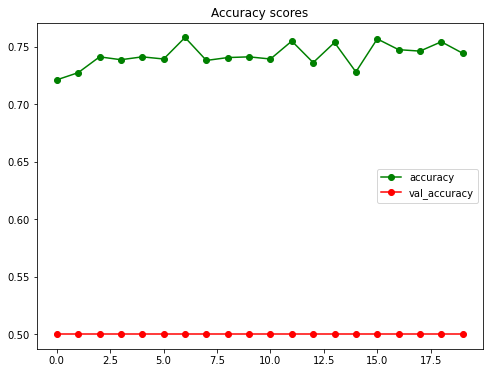

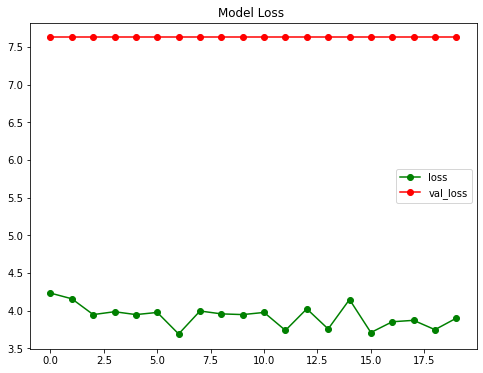

In [28]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history_ae.history['accuracy'],'go-')
plt.plot(history_ae.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Model Loss ')
plt.plot(history_ae.history['loss'],'go-')
plt.plot(history_ae.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [29]:
y_pred_ae = classifier.predict_generator(test_generator,624)

/tmp/ipykernel_72675/2274414236.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_ae = classifier.predict_generator(test_generator,624)


In [30]:
y_pred_ae_ = y_pred_ae
y_pred_ae[y_pred_ae >= 0.5] = 1
y_pred_ae[y_pred_ae <  0.5] = 0

auc score is :  0.47435897435897434


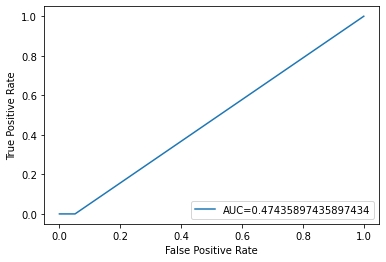

In [31]:
# f1_score = f1_score(y_test, y_pred_ae, average='binary')
# print("f1 score is: ", f1_score)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_ae_)
auc = metrics.roc_auc_score(y_test, y_pred_ae_)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [32]:
predictions = y_pred_ae.reshape(1, -1)[0]
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.36      0.95      0.52       234
   Normal (Class 1)       0.00      0.00      0.00       390

           accuracy                           0.36       624
          macro avg       0.18      0.47      0.26       624
       weighted avg       0.14      0.36      0.20       624



<AxesSubplot:>

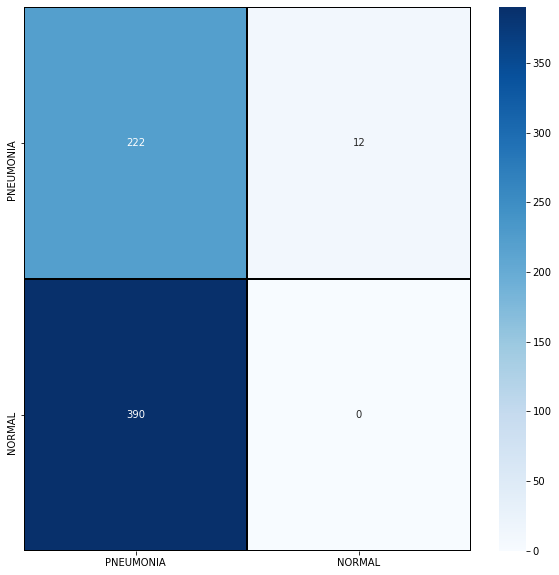

In [34]:
labels = ['PNEUMONIA', 'NORMAL']
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels,
            yticklabels=labels)

# Oversampling part

In [20]:
history_ae_over =model_ae.fit(
    train_generator_over,
    steps_per_epoch = 100,
    epochs=20,
    validation_data = valid_generator,
    #validation_steps=25
)

Epoch 1/20
100/100 [==============================] - 21s 206ms/step - loss: 14.1463 - accuracy: 0.0825 - val_loss: 6.8101 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 19s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 19s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/20
100/100 [==============================] - 19s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/20
100/100 [==============================] - 19s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/20
100/100 [==============================] - 20s 195ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/20
100/100 [==============================] - 19s 190ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - 

/tmp/ipykernel_122619/3509962012.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_ae_over = model_ae.evaluate_generator(test_generator, 624)[1]


/tmp/ipykernel_122619/3509962012.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_ae_over = model_ae.predict_generator(test_generator, 624)


auc score is :  0.5


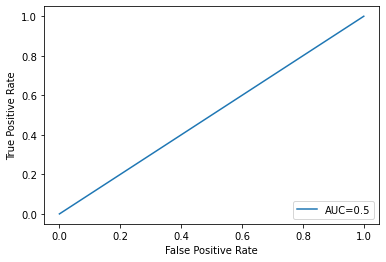

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.00      0.00      0.00       234
   Normal (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samiraalkaee/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

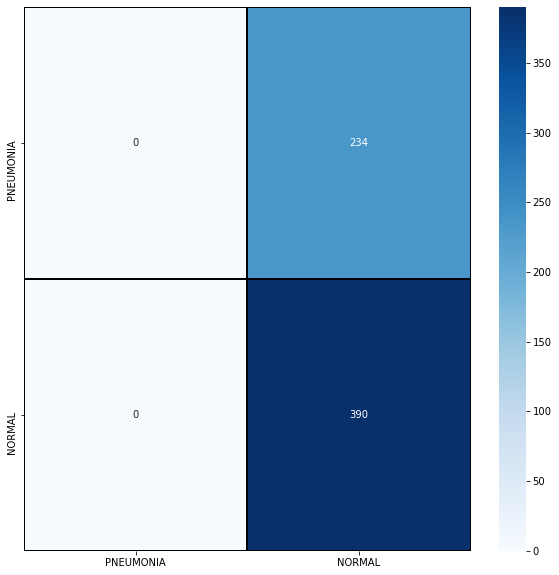

In [21]:
accuracy_ae_over = model_ae.evaluate_generator(test_generator, 624)[1]
y_pred_ae_over = model_ae.predict_generator(test_generator, 624)
y_pred_ae_over_ = y_pred_ae_over
y_pred_ae_over[y_pred_ae_over >= 0.5] = 1
y_pred_ae_over[y_pred_ae_over< 0.5] = 0
#y_pred_cnn = (y_pred).astype(int)
#y_pred
#f1_score(y_test, y_pred_cnn_, average=None)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_ae_over)
auc = metrics.roc_auc_score(y_test, y_pred_ae_over)
print("auc score is : ", auc)
#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
predictions = y_pred_ae_over.reshape(1, -1)[0]
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))
cm = confusion_matrix(y_test, predictions)
labels = ['PNEUMONIA', 'NORMAL']
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels,
            yticklabels=labels)